In [278]:
import pandas as pd
import warnings
warnings.filterwarnings('ignore')

import sys    
reload(sys)  
sys.setdefaultencoding('utf8')

import numpy as np

In [46]:
units = pd.read_excel('data/USUP-libellés.xls')

df = pd.read_csv('data/sample-data.csv')
df.columns = ['YEAR', 'MONTH', 'FLUX', 'ID', 'DEPT', 'CN ID 8', 'CPA6', 'PYOD', 'PAYP', 'VAT', 'PRIFAC', 'DEVFAC',
              'VFTE', 'VART', 'D_MASSE', 'MASSE', 'USUP', 'USUP_MT']
df['CN ID 8'] = df['CN ID 8'].astype(str)

In [50]:
dg = pd.read_csv('data/CN_2015.csv')
dg['CN ID 8'] = dg['Code'].astype(str).str.zfill(12).str[:8]
dg['Parent'] = dg['Parent'].astype(str).str[:8].str.zfill(8)


CN_full = dg[['Level','CN ID 8', 'Parent', 'Description']]
CN_full['CN ID 2'] = CN_full['CN ID 8'].str[:2]
CN_full['CN ID 4'] = CN_full['CN ID 8'].str[:4]
CN_full['CN ID 5'] = CN_full['CN ID 8'].str[:5]
CN_full['CN ID 6'] = CN_full['CN ID 8'].str[:7]

CN_full['CN label 2'] = CN_full.loc[CN_full.Level == 2]['Description']
CN_full['CN label 4'] = CN_full.loc[CN_full.Level == 3]['Description']

df = df.merge(CN_full[['CN ID 8', 'CN ID 4','CN ID 2']])

In [51]:
dg = pd.read_csv('data/CPA_2008.csv')
dg['Code'] = dg['Code'].str.replace('.', '')
CPA_full = dg.loc[dg.Level == 6][['Code', 'Description']].rename({'Code': 'CPA ID 6', 'Description':'CPA label 6'}, axis = 1)
CPA_full['CPA ID 4'] = CPA_full['CPA ID 6'].str[:4]
CPA_full['CPA ID 3'] = CPA_full['CPA ID 6'].str[:3]
CPA_full['CPA ID 2'] = CPA_full['CPA ID 6'].str[:2]

CPA_4 = dg.loc[dg.Level == 4][['Code', 'Description']].rename({'Code': 'CPA ID 4', 'Description':'CPA label 4'}, axis = 1)
CPA_3 = dg.loc[dg.Level == 3][['Code', 'Description']].rename({'Code': 'CPA ID 3', 'Description':'CPA label 3'}, axis = 1)
CPA_2 = dg.loc[dg.Level == 2][['Code', 'Description', 'Parent']].rename({'Code': 'CPA ID 2', 'Description':'CPA label 2', 'Parent' : 'CPA ID 1'}, axis = 1)

CPA_full = CPA_full.merge(CPA_4).merge(CPA_3).merge(CPA_2)


In [55]:

ref = df.groupby(['ID'])[['VFTE']].sum().rank(ascending = False, method = 'first').astype(int).reset_index().rename({'VFTE': 'rank_ID'}, axis = 1)

df_ = df.merge(ref, on = 'ID')

df_['FLUX'] = df_['FLUX'].replace({3: 1, 4: 2}).replace({1: 'Imp', 2: 'Exp'})

data = df_#.loc[df['FLUX'].isin([3, 4])]

CN_lev = '4'

data = data.merge(CN_full[['CN ID '+CN_lev, 'CN label '+CN_lev]].dropna().drop_duplicates())

data = data[['FLUX','ID', 'VAT', 'VFTE', 'CN ID '+CN_lev, 'CN label '+CN_lev, 'rank_ID']].loc[data['VFTE'] > 0]

# data = data.merge(firm_size.reset_index())
# data = data.loc[data.firm_size > 5]

#Select firms with both imp and exp
ImpExp = data.groupby(['rank_ID', 'FLUX']).sum().reset_index()
ImpExp_d = ImpExp['rank_ID'].duplicated(keep  = False).values
ImpExp_IDS = ImpExp[ImpExp_d].rank_ID.unique()

data = data.loc[data.rank_ID.isin(ImpExp_IDS)]

grouped = data.groupby(['rank_ID','FLUX','CN ID '+CN_lev, 'CN label '+CN_lev])
value = grouped.sum()[['VFTE']]
counts = grouped.count()[['ID']]
df_display = pd.concat([value, counts], axis = 1)


df_display.columns = ['value', 'counts']


# firm_size = log10(df_display.reset_index().groupby('rank_ID').sum()[['VFTE']])
# firm_size.columns = ['firm_size']

In [219]:
df1 = pd.DataFrame(df_display.reset_index().groupby('rank_ID')['CN ID '+CN_lev].unique())
df1['sets'] = [set(val) for val in df1['CN ID 4'].values]

l = len(df1)

df1 = df1.reset_index()[['rank_ID', 'sets']].head(l)

df2 = df1.add_suffix('_').head(l)

l = len(df2)

# df1.merge(df2, left_on= 'rank_ID', right_on = 'rank_ID_', how = 'outer')
df1 = pd.concat([df1]*l).reset_index(drop = True)
df2 = pd.concat([df2]*l).sort_values(by = 'rank_ID_').reset_index(drop = True)

df = pd.concat([df1, df2], axis = 1)

df['inters'] = [x[0] & x[1] for x in zip(df['sets'], df['sets_'])]

def similarity(x, y):
    a = np.true_divide(len(x & y),len(x))
    b = np.true_divide(len(x & y),len(y))
    return min(a, b)
    

df['inters_ct'] = [similarity(x[0], x[1]) for x in zip(df['sets'], df['sets_'])]

In [220]:
d_df = df.set_index(['rank_ID', 'rank_ID_'])['inters_ct'].unstack()

# import seaborn as sns
# cm = sns.light_palette("green", as_cmap=True)
# s = d_df.round(2).style.background_gradient(cmap=cm, low=0, high=.5)
# s

nw_data = pd.DataFrame(d_df.stack(), columns = ['weight'])
nw_data = nw_data.reset_index()[nw_data.reset_index()['rank_ID'] != nw_data.reset_index()['rank_ID_']].set_index(['rank_ID', 'rank_ID_'])


nw_data

weight
rank_ID rank_ID_          
1       2         0.039773
        3         0.047619
        4         0.000000
        5         0.000000
        6         0.166667
        7         0.000000
        8         0.000000
        9         0.055556
        10        0.083333
        11        0.064516
        12        0.000000
        13        0.000000
        14        0.000000
        15        0.000000
        16        0.025316
        17        0.027397
        18        0.040000
        19        0.076923
        20        0.051020
        21        0.053191
        22        0.026316
        23        0.000000
        25        0.115385
        27        0.081081
        28        0.000000
        29        0.047619
        31        0.000000
        32        0.000000
        33        0.012146
        34        0.100000
...                    ...
7134    7066      0.000000
        7069      0.000000
        7071      0.000000
        7072      0.000000
        7073      0.000000
        7075      0.000000
        7079      0.000000
        7083      0.000000
        7085      0.000000
        7088      0.000000
        7089      0.000000
        7094      0.000000
        7097      0.000000
        7104      0.000000
        7105      0.000000
        7107      0.000000
        7108      0.000000
        7110      0.000000
        7111      0.000000
        7116      0.000000
        7117      0.000000
        7118      0.000000
        7121      0.000000
        7125      0.000000
        7126      0.000000
        7127      0.000000
        7128      0.000000
        7130      0.000000
        7132      0.000000
        7133      0.000000

[16333722 rows x 1 columns]

In [268]:
# import networkx as nx

edges = nw_data.loc[nw_data['weight'] > .55].reset_index()

G = nx.from_pandas_dataframe(edges, 'rank_ID', 'rank_ID_', ['weight'])
grcc=sorted(nx.connected_component_subgraphs(G), key = len, reverse=True)


In [286]:
df_display.loc[200].style.bar(subset=['value', 'counts'], color='#d65f5f')

In [283]:
pd.options.display.max_rows = 400

df_display.loc[list(nx.node_connected_component(G, 120))].style.bar(subset=['value', 'counts'], color='#d65f5f')

KeyError: 120

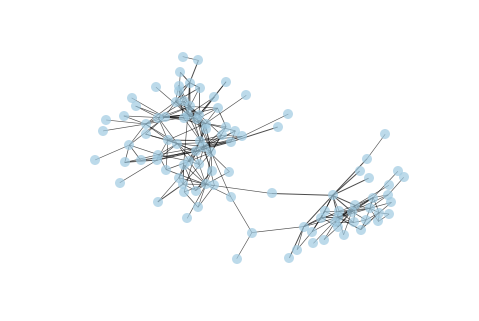

rank_ID  \
FLUX CN ID 4 CN label 4                                                    
Exp  6204    Women's or girls' suits, ensembles, jackets, bl...   265973   
     6110    Jerseys, pullovers, cardigans, waistcoats and s...   260413   
     6104    Women's or girls' suits, ensembles, jackets, bl...   232726   
     4202    Trunks, suitcases, vanity cases, executive-case...   159920   
     6203    Men's or boys' suits, ensembles, jackets, blaze...   147433   
     6109    T-shirts, singlets and other vests, knitted or ...   248436   
     6403    Footwear with outer soles of rubber, plastics, ...   102808   
     6202    Women's or girls' overcoats, car coats, capes, ...   207388   
     6206    Women's or girls' blouses, shirts and shirt-blo...   212849   
Imp  6204    Women's or girls' suits, ensembles, jackets, bl...   177633   
Exp  6111    Babies' garments and clothing accessories, knit...    57564   
     6209    Babies' garments and clothing accessories             55602   
     6211    Tracksuits, ski suits and swimwear; other garments   170014   
     6201    Men's or boys' overcoats, car coats, capes, clo...   130096   
     6205    Men's or boys' shirts                                122710   
     6214    Shawls, scarves, mufflers, mantillas, veils and...   140226   
Imp  6110    Jerseys, pullovers, cardigans, waistcoats and s...   137069   
Exp  6402    Other footwear with outer soles and uppers of r...    59489   
     6106    Women's or girls' blouses, shirts and shirt-blo...   142764   
     6115    Pantyhose, tights, stockings, socks and other h...    72200   

                                                                   value  \
FLUX CN ID 4 CN label 4                                                    
Exp  6204    Women's or girls' suits, ensembles, jackets, bl...  3342483   
     6110    Jerseys, pullovers, cardigans, waistcoats and s...  2420702   
     6104    Women's or girls' suits, ensembles, jackets, bl...  1104057   
     4202    Trunks, suitcases, vanity cases, executive-case...  5487589   
     6203    Men's or boys' suits, ensembles, jackets, blaze...  2961039   
     6109    T-shirts, singlets and other vests, knitted or ...  1554947   
     6403    Footwear with outer soles of rubber, plastics, ...  2739329   
     6202    Women's or girls' overcoats, car coats, capes, ...  1323269   
     6206    Women's or girls' blouses, shirts and shirt-blo...   790221   
Imp  6204    Women's or girls' suits, ensembles, jackets, bl...  9409707   
Exp  6111    Babies' garments and clothing accessories, knit...  1160137   
     6209    Babies' garments and clothing accessories            910368   
     6211    Tracksuits, ski suits and swimwear; other garments  1965205   
     6201    Men's or boys' overcoats, car coats, capes, clo...   574931   
     6205    Men's or boys' shirts                                869131   
     6214    Shawls, scarves, mufflers, mantillas, veils and...   244279   
Imp  6110    Jerseys, pullovers, cardigans, waistcoats and s...  6092059   
Exp  6402    Other footwear with outer soles and uppers of r...   763368   
     6106    Women's or girls' blouses, shirts and shirt-blo...   187007   
     6115    Pantyhose, tights, stockings, socks and other h...   244913   

                                                                 counts  
FLUX CN ID 4 CN label 4                                                  
Exp  6204    Women's or girls' suits, ensembles, jackets, bl...    2068  
     6110    Jerseys, pullovers, cardigans, waistcoats and s...    1014  
     6104    Women's or girls' suits, ensembles, jackets, bl...     941  
     4202    Trunks, suitcases, vanity cases, executive-case...     724  
     6203    Men's or boys' suits, ensembles, jackets, blaze...     695  
     6109    T-shirts, singlets and other vests, knitted or ...     603  
     6403    Footwear with outer soles of rubber, plastics, ...     560  
     6202    Women's or girls' overcoats, car coats, 

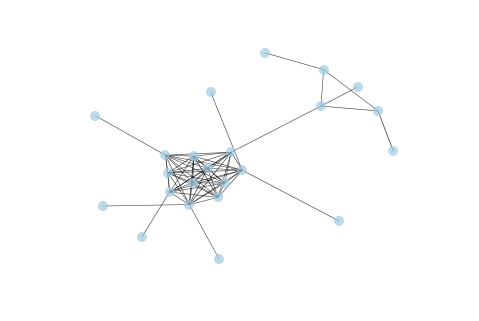

rank_ID  \
FLUX CN ID 4 CN label 4                                                    
Exp  9018    Instruments and appliances used in medical, sur...    51203   
     9021    Orthopaedic appliances, including crutches, sur...    29995   
Imp  9018    Instruments and appliances used in medical, sur...    52848   
     9021    Orthopaedic appliances, including crutches, sur...    49993   
Exp  3004    Medicaments (excluding goods of heading 3002, 3...     3106   
Imp  3926    Other articles of plastics and articles of othe...    16109   
Exp  8536    Electrical apparatus for switching or protectin...    11075   
Imp  8536    Electrical apparatus for switching or protectin...    14012   
Exp  3917    Tubes, pipes and hoses, and fittings therefor (...    15529   
Imp  3917    Tubes, pipes and hoses, and fittings therefor (...    11868   
     3004    Medicaments (excluding goods of heading 3002, 3...     1122   
     7419    Other articles of copper                               5502   
     3901    Polymers of ethylene, in primary forms                 9956   
Exp  4911    Other printed matter, including printed picture...     4518   
     3006    Pharmaceutical goods specified in note 4 to thi...     8032   
Imp  8480    Moulding boxes for metal foundry; mould bases; ...     6127   
     9023    Instruments, apparatus and models, designed for...     3656   
     8482    Ball or roller bearings                                4598   
Exp  2836    Carbonates; peroxocarbonates (percarbonates); c...      814   
Imp  8479    Machines and mechanical appliances having indiv...     5192   

                                                                    value  \
FLUX CN ID 4 CN label 4                                                     
Exp  9018    Instruments and appliances used in medical, sur...   1153304   
     9021    Orthopaedic appliances, including crutches, sur...   2147189   
Imp  9018    Instruments and appliances used in medical, sur...    548012   
     9021    Orthopaedic appliances, including crutches, sur...  12854730   
Exp  3004    Medicaments (excluding goods of heading 3002, 3...   3801016   
Imp  3926    Other articles of plastics and articles of othe...     85539   
Exp  8536    Electrical apparatus for switching or protectin...     30166   
Imp  8536    Electrical apparatus for switching or protectin...    187841   
Exp  3917    Tubes, pipes and hoses, and fittings therefor (...     19305   
Imp  3917    Tubes, pipes and hoses, and fittings therefor (...     46272   
     3004    Medicaments (excluding goods of heading 3002, 3...   1653912   
     7419    Other articles of copper                                5088   
     3901    Polymers of ethylene, in primary forms                393429   
Exp  4911    Other printed matter, including printed picture...        60   
     3006    Pharmaceutical goods specified in note 4 to thi...     16426   
Imp  8480    Moulding boxes for metal foundry; mould bases; ...      4674   
     9023    Instruments, apparatus and models, designed for...       437   
     8482    Ball or roller bearings                                 1467   
Exp  2836    Carbonates; peroxocarbonates (percarbonates); c...       945   
Imp  8479    Machines and mechanical appliances having indiv...      3463   

                                                                 counts  
FLUX CN ID 4 CN label 4                                                  
Exp  9018    Instruments and appliances used in medical, sur...      52  
     9021    Orthopaedic appliances, including crutches, sur...      31  
Imp  9018    Instruments and appliances used in medical, sur...      29  
     9021    Orthopaedic appliances, including crutches, sur...      24  
Exp  3004    Medicaments (excluding goods of heading 3002, 3...      12  
Imp  3926    Other articles of plastics and articles of othe...       6  
Exp  8536    Electrical apparatus for switching or protectin...       5  
Imp  8536    Electrical apparat

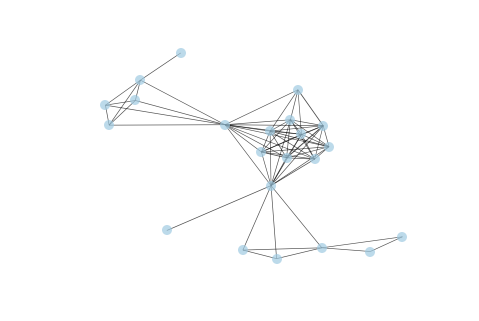

rank_ID  \
FLUX CN ID 4 CN label 4                                                    
Exp  2204    Wine of fresh grapes, including fortified wines...    70679   
     3923    Articles for the conveyance or packing of goods...     9036   
Imp  7010    Carboys, bottles, flasks, jars, pots, phials, a...    43674   
     2204    Wine of fresh grapes, including fortified wines...    17629   
Exp  4415    Packing cases, boxes, crates, drums and similar...    12839   
     7010    Carboys, bottles, flasks, jars, pots, phials, a...     4465   
Imp  3923    Articles for the conveyance or packing of goods...    13764   
     4503    Articles of natural cork                              19349   
     8480    Moulding boxes for metal foundry; mould bases; ...     4465   
     3506    Prepared glues and other prepared adhesives, no...    11969   
     4819    Cartons, boxes, cases, bags and other packing c...    10474   
Exp  2206    Other fermented beverages (for example, cider, ...     1435   
Imp  4415    Packing cases, boxes, crates, drums and similar...     3681   
     8422    Dishwashing machines; machinery for cleaning or...      926   

                                                                   value  \
FLUX CN ID 4 CN label 4                                                    
Exp  2204    Wine of fresh grapes, including fortified wines...  7124451   
     3923    Articles for the conveyance or packing of goods...    62056   
Imp  7010    Carboys, bottles, flasks, jars, pots, phials, a...   389814   
     2204    Wine of fresh grapes, including fortified wines...   346523   
Exp  4415    Packing cases, boxes, crates, drums and similar...    10862   
     7010    Carboys, bottles, flasks, jars, pots, phials, a...   100957   
Imp  3923    Articles for the conveyance or packing of goods...   170267   
     4503    Articles of natural cork                              65157   
     8480    Moulding boxes for metal foundry; mould bases; ...    96730   
     3506    Prepared glues and other prepared adhesives, no...    54592   
     4819    Cartons, boxes, cases, bags and other packing c...    28226   
Exp  2206    Other fermented beverages (for example, cider, ...      225   
Imp  4415    Packing cases, boxes, crates, drums and similar...     2287   
     8422    Dishwashing machines; machinery for cleaning or...     1632   

                                                                 counts  
FLUX CN ID 4 CN label 4                                                  
Exp  2204    Wine of fresh grapes, including fortified wines...     477  
     3923    Articles for the conveyance or packing of goods...      15  
Imp  7010    Carboys, bottles, flasks, jars, pots, phials, a...      13  
     2204    Wine of fresh grapes, including fortified wines...       8  
Exp  4415    Packing cases, boxes, crates, drums and similar...       7  
     7010    Carboys, bottles, flasks, jars, pots, phials, a...       7  
Imp  3923    Articles for the conveyance or packing of goods...       5  
     4503    Articles of natural cork                                 5  
     8480    Moulding boxes for metal foundry; mould bases; ...       4  
     3506    Prepared glues and other prepared adhesives, no...       3  
     4819    Cartons, boxes, cases, bags and other packing c...       3  
Exp  2206    Other fermented beverages (for example, cider, ...       1  
Imp  4415    Packing cases, boxes, crates, drums and similar...       1  
     8422    Dishwashing machines; machinery for cleaning or...       1

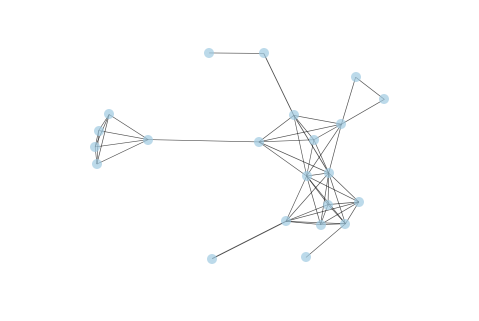

rank_ID  \
FLUX CN ID 4 CN label 4                                                    
Exp  8541    Diodes, transistors and similar semiconductor d...     7185   
     8542    Electronic integrated circuits                         7743   
     8517    Telephone sets, including telephones for cellul...    16894   
     8471    Automatic data-processing machines and units th...    25415   
Imp  8542    Electronic integrated circuits                         5363   
Exp  8443    Printing machinery used for printing by means o...    10808   
Imp  8517    Telephone sets, including telephones for cellul...    20415   
     8541    Diodes, transistors and similar semiconductor d...     3344   
Exp  8473    Parts and accessories (other than covers, carry...    19207   
Imp  8471    Automatic data-processing machines and units th...    22205   
     8473    Parts and accessories (other than covers, carry...    17808   
Exp  8528    Monitors and projectors, not incorporating tele...     9806   
Imp  8544    Insulated (including enamelled or anodised) wir...     4428   
     8443    Printing machinery used for printing by means o...     4910   
     8504    Electrical transformers, static converters (for...     2918   
     9013    Liquid crystal devices not constituting article...     3057   
Exp  8518    Microphones and stands therefor; loudspeakers, ...     6756   
Imp  8537    Boards, panels, consoles, desks, cabinets and o...     2799   
Exp  3402    Organic surface-active agents (other than soap)...     4910   
Imp  8412    Other engines and motors                                626   

                                                                   value  \
FLUX CN ID 4 CN label 4                                                    
Exp  8541    Diodes, transistors and similar semiconductor d...  3649113   
     8542    Electronic integrated circuits                      7595922   
     8517    Telephone sets, including telephones for cellul...  1055029   
     8471    Automatic data-processing machines and units th...  3111094   
Imp  8542    Electronic integrated circuits                      1894277   
Exp  8443    Printing machinery used for printing by means o...   295274   
Imp  8517    Telephone sets, including telephones for cellul...  3582846   
     8541    Diodes, transistors and similar semiconductor d...   589139   
Exp  8473    Parts and accessories (other than covers, carry...   323184   
Imp  8471    Automatic data-processing machines and units th...   120167   
     8473    Parts and accessories (other than covers, carry...   526882   
Exp  8528    Monitors and projectors, not incorporating tele...    37353   
Imp  8544    Insulated (including enamelled or anodised) wir...   110730   
     8443    Printing machinery used for printing by means o...    10048   
     8504    Electrical transformers, static converters (for...  1047802   
     9013    Liquid crystal devices not constituting article...     4994   
Exp  8518    Microphones and stands therefor; loudspeakers, ...    16911   
Imp  8537    Boards, panels, consoles, desks, cabinets and o...     4862   
Exp  3402    Organic surface-active agents (other than soap)...       81   
Imp  8412    Other engines and motors                               1865   

                                                                 counts  
FLUX CN ID 4 CN label 4                                                  
Exp  8541    Diodes, transistors and similar semiconductor d...      79  
     8542    Electronic integrated circuits                          62  
     8517    Telephone sets, including telephones for cellul...      51  
     8471    Automatic data-processing machines and units th...      38  
Imp  8542    Electronic integrated circuits                          23  
Exp  8443    Printing machinery used for printing by means o...      19  
Imp  8517    Telephone sets, including telephones for cellul...      17  
     8541    Diodes, transistors and similar semicond

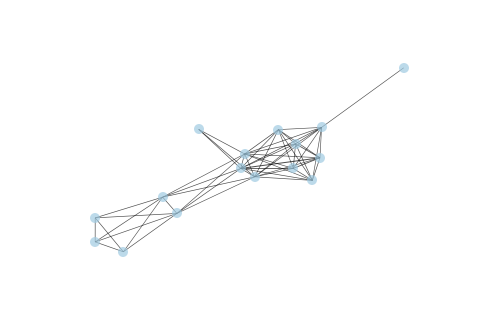

rank_ID  \
FLUX CN ID 4 CN label 4                                                    
Exp  6403    Footwear with outer soles of rubber, plastics, ...    38478   
Imp  6403    Footwear with outer soles of rubber, plastics, ...    44757   
Exp  6402    Other footwear with outer soles and uppers of r...    22798   
     6404    Footwear with outer soles of rubber, plastics, ...    39179   
Imp  6402    Other footwear with outer soles and uppers of r...    32623   
     6404    Footwear with outer soles of rubber, plastics, ...    18689   
Exp  6401    Waterproof footwear with outer soles and uppers...    16757   
     6405    Other footwear                                         8891   
     4202    Trunks, suitcases, vanity cases, executive-case...     1871   
Imp  3920    Other plates, sheets, film, foil and strip, of ...     3249   
     4114    Chamois (including combination chamois) leather...     3954   
     6401    Waterproof footwear with outer soles and uppers...     3950   
     9609    Pencils (other than pencils of heading 9608), c...     2841   

                                                                   value  \
FLUX CN ID 4 CN label 4                                                    
Exp  6403    Footwear with outer soles of rubber, plastics, ...   473950   
Imp  6403    Footwear with outer soles of rubber, plastics, ...  2303453   
Exp  6402    Other footwear with outer soles and uppers of r...   148834   
     6404    Footwear with outer soles of rubber, plastics, ...   111466   
Imp  6402    Other footwear with outer soles and uppers of r...   686308   
     6404    Footwear with outer soles of rubber, plastics, ...   516314   
Exp  6401    Waterproof footwear with outer soles and uppers...    56922   
     6405    Other footwear                                         5887   
     4202    Trunks, suitcases, vanity cases, executive-case...      856   
Imp  3920    Other plates, sheets, film, foil and strip, of ...      494   
     4114    Chamois (including combination chamois) leather...    15770   
     6401    Waterproof footwear with outer soles and uppers...    90667   
     9609    Pencils (other than pencils of heading 9608), c...       26   

                                                                 counts  
FLUX CN ID 4 CN label 4                                                  
Exp  6403    Footwear with outer soles of rubber, plastics, ...     228  
Imp  6403    Footwear with outer soles of rubber, plastics, ...      78  
Exp  6402    Other footwear with outer soles and uppers of r...      41  
     6404    Footwear with outer soles of rubber, plastics, ...      37  
Imp  6402    Other footwear with outer soles and uppers of r...      23  
     6404    Footwear with outer soles of rubber, plastics, ...      19  
Exp  6401    Waterproof footwear with outer soles and uppers...      17  
     6405    Other footwear                                           4  
     4202    Trunks, suitcases, vanity cases, executive-case...       2  
Imp  3920    Other plates, sheets, film, foil and strip, of ...       1  
     4114    Chamois (including combination chamois) leather...       1  
     6401    Waterproof footwear with outer soles and uppers...       1  
     9609    Pencils (other than pencils of heading 9608), c...       1

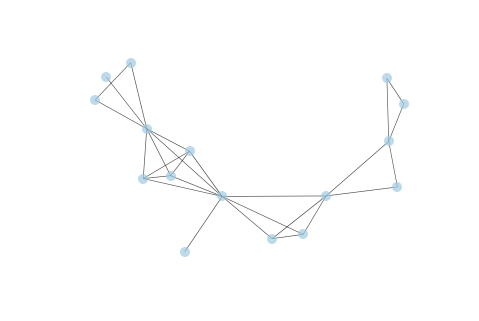

rank_ID  \
FLUX CN ID 4 CN label 4                                                    
Exp  8708    Parts and accessories of the motor vehicles of ...    30513   
     7326    Other articles of iron or steel                       18894   
Imp  8708    Parts and accessories of the motor vehicles of ...    14739   
Exp  8482    Ball or roller bearings                                 329   
Imp  4016    Other articles of vulcanised rubber other than ...    14217   
     7306    Other tubes, pipes and hollow profiles (for exa...    11817   
     7220    Flat-rolled products of stainless steel, of a w...     3003   
Exp  8411    Turbojets, turbopropellers and other gas turbines       329   
Imp  7326    Other articles of iron or steel                        7771   
Exp  4016    Other articles of vulcanised rubber other than ...     3247   
     8431    Parts suitable for use solely or principally wi...     4289   
Imp  8482    Ball or roller bearings                                3634   
     2818    Artificial corundum, whether or not chemically ...     4492   
     8431    Parts suitable for use solely or principally wi...     3251   

                                                                   value  \
FLUX CN ID 4 CN label 4                                                    
Exp  8708    Parts and accessories of the motor vehicles of ...  3294577   
     7326    Other articles of iron or steel                      846617   
Imp  8708    Parts and accessories of the motor vehicles of ...  2380213   
Exp  8482    Ball or roller bearings                             2892735   
Imp  4016    Other articles of vulcanised rubber other than ...  1041651   
     7306    Other tubes, pipes and hollow profiles (for exa...   580907   
     7220    Flat-rolled products of stainless steel, of a w...   302735   
Exp  8411    Turbojets, turbopropellers and other gas turbines    730136   
Imp  7326    Other articles of iron or steel                       11752   
Exp  4016    Other articles of vulcanised rubber other than ...    19320   
     8431    Parts suitable for use solely or principally wi...    48132   
Imp  8482    Ball or roller bearings                               44818   
     2818    Artificial corundum, whether or not chemically ...     1368   
     8431    Parts suitable for use solely or principally wi...     3222   

                                                                 counts  
FLUX CN ID 4 CN label 4                                                  
Exp  8708    Parts and accessories of the motor vehicles of ...      53  
     7326    Other articles of iron or steel                         16  
Imp  8708    Parts and accessories of the motor vehicles of ...      12  
Exp  8482    Ball or roller bearings                                  9  
Imp  4016    Other articles of vulcanised rubber other than ...       9  
     7306    Other tubes, pipes and hollow profiles (for exa...       8  
     7220    Flat-rolled products of stainless steel, of a w...       7  
Exp  8411    Turbojets, turbopropellers and other gas turbines        4  
Imp  7326    Other articles of iron or steel                          4  
Exp  4016    Other articles of vulcanised rubber other than ...       3  
     8431    Parts suitable for use solely or principally wi...       3  
Imp  8482    Ball or roller bearings                                  2  
     2818    Artificial corundum, whether or not chemically ...       1  
     8431    Parts suitable for use solely or principally wi...       1

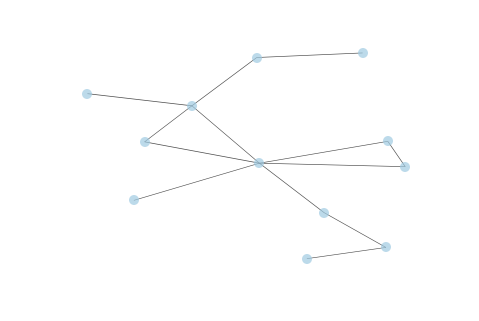

rank_ID  \
FLUX CN ID 4 CN label 4                                                    
Exp  8504    Electrical transformers, static converters (for...    17415   
Imp  8517    Telephone sets, including telephones for cellul...    12628   
     8536    Electrical apparatus for switching or protectin...    26728   
     8544    Insulated (including enamelled or anodised) wir...    21881   
Exp  8544    Insulated (including enamelled or anodised) wir...    23723   
     8536    Electrical apparatus for switching or protectin...    21090   
Imp  8504    Electrical transformers, static converters (for...    19984   
Exp  8516    Electric instantaneous or storage water heaters...     3226   
     8529    Parts suitable for use solely or principally wi...    12172   
     8517    Telephone sets, including telephones for cellul...     9898   
     8538    Parts suitable for use solely or principally wi...     7918   
Imp  3909    Amino-resins, phenolic resins and polyurethanes...    10605   
     7614    Stranded wire, cables, plaited bands and the li...     6181   
     8516    Electric instantaneous or storage water heaters...     3226   
     8529    Parts suitable for use solely or principally wi...     6772   
     8547    Insulating fittings for electrical machines, ap...     5582   

                                                                   value  \
FLUX CN ID 4 CN label 4                                                    
Exp  8504    Electrical transformers, static converters (for...   172553   
Imp  8517    Telephone sets, including telephones for cellul...  2851490   
     8536    Electrical apparatus for switching or protectin...   268267   
     8544    Insulated (including enamelled or anodised) wir...   346158   
Exp  8544    Insulated (including enamelled or anodised) wir...   366283   
     8536    Electrical apparatus for switching or protectin...     7223   
Imp  8504    Electrical transformers, static converters (for...    93642   
Exp  8516    Electric instantaneous or storage water heaters...   276841   
     8529    Parts suitable for use solely or principally wi...    23958   
     8517    Telephone sets, including telephones for cellul...   204314   
     8538    Parts suitable for use solely or principally wi...   224814   
Imp  3909    Amino-resins, phenolic resins and polyurethanes...     7830   
     7614    Stranded wire, cables, plaited bands and the li...    18131   
     8516    Electric instantaneous or storage water heaters...     4380   
     8529    Parts suitable for use solely or principally wi...    69583   
     8547    Insulating fittings for electrical machines, ap...     2656   

                                                                 counts  
FLUX CN ID 4 CN label 4                                                  
Exp  8504    Electrical transformers, static converters (for...       9  
Imp  8517    Telephone sets, including telephones for cellul...       9  
     8536    Electrical apparatus for switching or protectin...       9  
     8544    Insulated (including enamelled or anodised) wir...       9  
Exp  8544    Insulated (including enamelled or anodised) wir...       8  
     8536    Electrical apparatus for switching or protectin...       6  
Imp  8504    Electrical transformers, static converters (for...       6  
Exp  8516    Electric instantaneous or storage water heaters...       4  
     8529    Parts suitable for use solely or principally wi...       4  
     8517    Telephone sets, including telephones for cellul...       3  
     8538    Parts suitable for use solely or principally wi...       3  
Imp  3909    Amino-resins, phenolic resins and polyurethanes...       2  
     7614    Stranded wire, cables, plaited bands and the li...       1  
     8516    Electric instantaneous or storage water heaters...       1  
     8529    Parts suitable for use solely or principally wi...       1  
     8547    Insulating fittings for electrical machines, ap...      

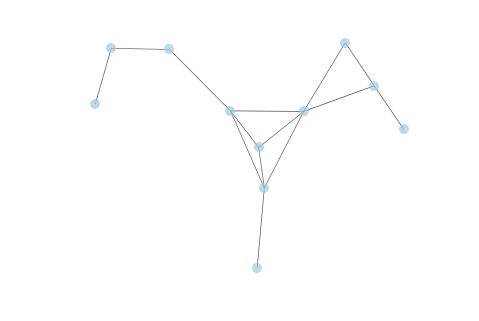

rank_ID  \
FLUX CN ID 4 CN label 4                                                    
Exp  3926    Other articles of plastics and articles of othe...    23466   
     8708    Parts and accessories of the motor vehicles of ...    15297   
Imp  8708    Parts and accessories of the motor vehicles of ...     2617   
     7211    Flat-rolled products of iron or non-alloy steel...     4502   
     8480    Moulding boxes for metal foundry; mould bases; ...     5999   
     3926    Other articles of plastics and articles of othe...     7712   
     3921    Other plates, sheets, film, foil and strip, of ...     9770   
     7210    Flat-rolled products of iron or non-alloy steel...     2789   
     7225    Flat-rolled products of other alloy steel, of a...     4653   
Exp  7225    Flat-rolled products of other alloy steel, of a...     4653   
Imp  3907    Polyacetals, other polyethers and epoxide resin...     5061   
     7604    Aluminium bars, rods and profiles                      2858   
Exp  7211    Flat-rolled products of iron or non-alloy steel...     3925   
Imp  3911    Petroleum resins, coumarone-indene resins, poly...     5777   
     7208    Flat-rolled products of iron or non-alloy steel...     3925   
     8512    Electrical lighting or signalling equipment (ex...     4580   

                                                                   value  \
FLUX CN ID 4 CN label 4                                                    
Exp  3926    Other articles of plastics and articles of othe...   545554   
     8708    Parts and accessories of the motor vehicles of ...   780255   
Imp  8708    Parts and accessories of the motor vehicles of ...  2383439   
     7211    Flat-rolled products of iron or non-alloy steel...   546235   
     8480    Moulding boxes for metal foundry; mould bases; ...   482403   
     3926    Other articles of plastics and articles of othe...   212275   
     3921    Other plates, sheets, film, foil and strip, of ...   313514   
     7210    Flat-rolled products of iron or non-alloy steel...  1321334   
     7225    Flat-rolled products of other alloy steel, of a...   544861   
Exp  7225    Flat-rolled products of other alloy steel, of a...    41470   
Imp  3907    Polyacetals, other polyethers and epoxide resin...    19986   
     7604    Aluminium bars, rods and profiles                    126038   
Exp  7211    Flat-rolled products of iron or non-alloy steel...    42052   
Imp  3911    Petroleum resins, coumarone-indene resins, poly...    91489   
     7208    Flat-rolled products of iron or non-alloy steel...     8627   
     8512    Electrical lighting or signalling equipment (ex...      950   

                                                                 counts  
FLUX CN ID 4 CN label 4                                                  
Exp  3926    Other articles of plastics and articles of othe...      17  
     8708    Parts and accessories of the motor vehicles of ...      15  
Imp  8708    Parts and accessories of the motor vehicles of ...      10  
     7211    Flat-rolled products of iron or non-alloy steel...       6  
     8480    Moulding boxes for metal foundry; mould bases; ...       6  
     3926    Other articles of plastics and articles of othe...       4  
     3921    Other plates, sheets, film, foil and strip, of ...       3  
     7210    Flat-rolled products of iron or non-alloy steel...       3  
     7225    Flat-rolled products of other alloy steel, of a...       3  
Exp  7225    Flat-rolled products of other alloy steel, of a...       2  
Imp  3907    Polyacetals, other polyethers and epoxide resin...       2  
     7604    Aluminium bars, rods and profiles                        2  
Exp  7211    Flat-rolled products of iron or non-alloy steel...       1  
Imp  3911    Petroleum resins, coumarone-indene resins, poly...       1  
     7208    Flat-rolled products of iron or non-alloy steel...       1  
     8512    Electrical lighting or signalling equipment (ex...      

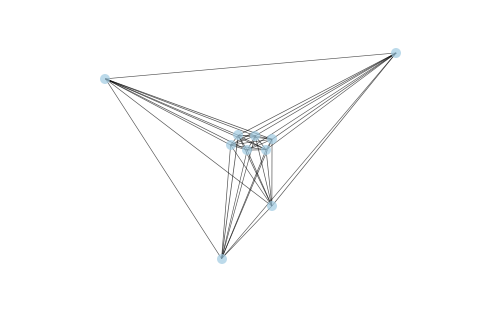

,,,rank_ID,value,counts
FLUX,CN ID 4,CN label 4,,,
Exp,2204,"Wine of fresh grapes, including fortified wines; grape must other than that of heading 2009",31614,6128497,67
Imp,2204,"Wine of fresh grapes, including fortified wines; grape must other than that of heading 2009",31614,1322044,18


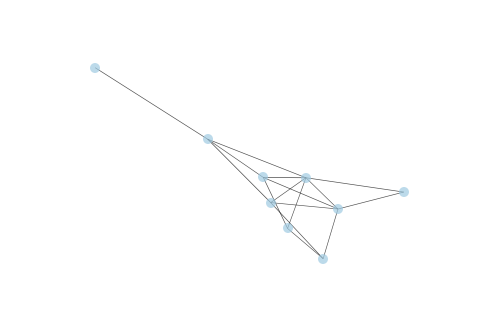

rank_ID  \
FLUX CN ID 4 CN label 4                                                    
Exp  8708    Parts and accessories of the motor vehicles of ...      463   
Imp  8708    Parts and accessories of the motor vehicles of ...     1784   
Exp  7318    Screws, bolts, nuts, coach screws, screw hooks,...      463   
Imp  7318    Screws, bolts, nuts, coach screws, screw hooks,...     1899   
Exp  8421    Centrifuges, including centrifugal dryers; filt...      463   
     8536    Electrical apparatus for switching or protectin...      463   
     4016    Other articles of vulcanised rubber other than ...      463   
     8413    Pumps for liquids, whether or not fitted with a...      288   
Imp  4016    Other articles of vulcanised rubber other than ...     1899   
     4009    Tubes, pipes and hoses, of vulcanised rubber ot...     1784   
     8536    Electrical apparatus for switching or protectin...     1784   
Exp  8483    Transmission shafts (including cam shafts and c...      420   
     8512    Electrical lighting or signalling equipment (ex...      245   
     4009    Tubes, pipes and hoses, of vulcanised rubber ot...     1865   
     8482    Ball or roller bearings                                 463   
Imp  8421    Centrifuges, including centrifugal dryers; filt...     1899   
Exp  8414    Air or vacuum pumps, air or other gas compresso...      463   
     8481    Taps, cocks, valves and similar appliances for ...      463   
     8511    Electrical ignition or starting equipment of a ...      463   
Imp  8413    Pumps for liquids, whether or not fitted with a...     1899   

                                                                    value  \
FLUX CN ID 4 CN label 4                                                     
Exp  8708    Parts and accessories of the motor vehicles of ...  18582022   
Imp  8708    Parts and accessories of the motor vehicles of ...  18277587   
Exp  7318    Screws, bolts, nuts, coach screws, screw hooks,...    481001   
Imp  7318    Screws, bolts, nuts, coach screws, screw hooks,...    271236   
Exp  8421    Centrifuges, including centrifugal dryers; filt...   2366720   
     8536    Electrical apparatus for switching or protectin...    438383   
     4016    Other articles of vulcanised rubber other than ...    355676   
     8413    Pumps for liquids, whether or not fitted with a...   2033690   
Imp  4016    Other articles of vulcanised rubber other than ...   1051392   
     4009    Tubes, pipes and hoses, of vulcanised rubber ot...   1145790   
     8536    Electrical apparatus for switching or protectin...    950259   
Exp  8483    Transmission shafts (including cam shafts and c...   1461892   
     8512    Electrical lighting or signalling equipment (ex...    639580   
     4009    Tubes, pipes and hoses, of vulcanised rubber ot...    302641   
     8482    Ball or roller bearings                               339420   
Imp  8421    Centrifuges, including centrifugal dryers; filt...    569965   
Exp  8414    Air or vacuum pumps, air or other gas compresso...    510458   
     8481    Taps, cocks, valves and similar appliances for ...    490009   
     8511    Electrical ignition or starting equipment of a ...    429596   
Imp  8413    Pumps for liquids, whether or not fitted with a...   3528375   

                                                                 counts  
FLUX CN ID 4 CN label 4                                                  
Exp  8708    Parts and accessories of the motor vehicles of ...     940  
Imp  8708    Parts and accessories of the motor vehicles of ...     640  
Exp  7318    Screws, bolts, nuts, coach screws, screw hooks,...     426  
Imp  7318    Screws, bolts, nuts, coach screws, screw hooks,...     324  
Exp  8421    Centrifuges, including centrifugal dryers; filt...     274  
     8536    Electrical apparatus for switching or protectin...     231  
     4016    Other articles of vulcanised rubber other than ...     206  
     8413    Pumps for liquids,

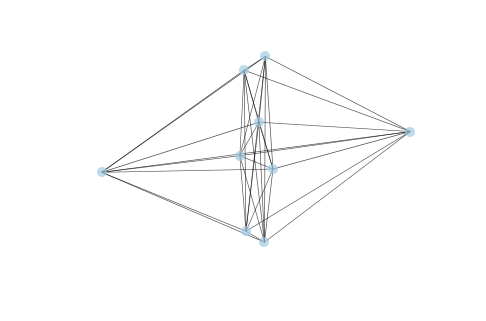

,,,rank_ID,value,counts
FLUX,CN ID 4,CN label 4,,,
Exp,8708,Parts and accessories of the motor vehicles of headings 8701 to 8705,29720,6172505,14
Imp,8708,Parts and accessories of the motor vehicles of headings 8701 to 8705,29720,2800491,14


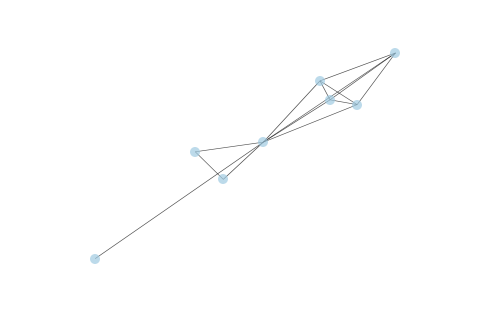

rank_ID  \
FLUX CN ID 4 CN label 4                                                    
Exp  3920    Other plates, sheets, film, foil and strip, of ...    19356   
Imp  3901    Polymers of ethylene, in primary forms                19695   
Exp  3902    Polymers of propylene or of other olefins, in p...     4439   
Imp  3902    Polymers of propylene or of other olefins, in p...     5902   
     3920    Other plates, sheets, film, foil and strip, of ...     5838   
     3215    Printing ink, writing or drawing ink and other ...     3418   
Exp  3901    Polymers of ethylene, in primary forms                  618   
Imp  2901    Acyclic hydrocarbons                                    618   
     4415    Packing cases, boxes, crates, drums and similar...     2117   
     8477    Machinery for working rubber or plastics or for...     3821   

                                                                   value  \
FLUX CN ID 4 CN label 4                                                    
Exp  3920    Other plates, sheets, film, foil and strip, of ...  1079636   
Imp  3901    Polymers of ethylene, in primary forms               921602   
Exp  3902    Polymers of propylene or of other olefins, in p...   208543   
Imp  3902    Polymers of propylene or of other olefins, in p...   362340   
     3920    Other plates, sheets, film, foil and strip, of ...    13756   
     3215    Printing ink, writing or drawing ink and other ...    68225   
Exp  3901    Polymers of ethylene, in primary forms               532768   
Imp  2901    Acyclic hydrocarbons                                1543687   
     4415    Packing cases, boxes, crates, drums and similar...     5566   
     8477    Machinery for working rubber or plastics or for...    21666   

                                                                 counts  
FLUX CN ID 4 CN label 4                                                  
Exp  3920    Other plates, sheets, film, foil and strip, of ...      27  
Imp  3901    Polymers of ethylene, in primary forms                   8  
Exp  3902    Polymers of propylene or of other olefins, in p...       7  
Imp  3902    Polymers of propylene or of other olefins, in p...       3  
     3920    Other plates, sheets, film, foil and strip, of ...       3  
     3215    Printing ink, writing or drawing ink and other ...       2  
Exp  3901    Polymers of ethylene, in primary forms                   1  
Imp  2901    Acyclic hydrocarbons                                     1  
     4415    Packing cases, boxes, crates, drums and similar...       1  
     8477    Machinery for working rubber or plastics or for...       1

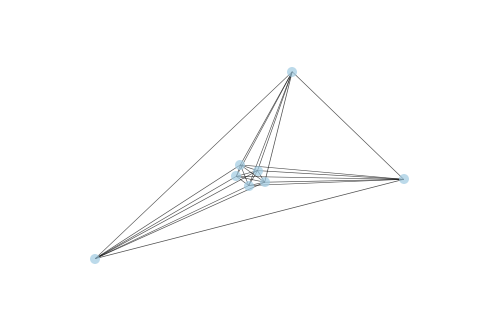

,,,rank_ID,value,counts
FLUX,CN ID 4,CN label 4,,,
Exp,4202,"Trunks, suitcases, vanity cases, executive-cases, briefcases, school satchels, spectacle cases, binocular cases, camera cases, musical instrument cases, gun cases, holsters and similar containers; travelling-bags, insulated food or beverages bags, toilet bags, rucksacks, handbags, shopping-bags, wallets, purses, map-cases, cigarette-cases, tobacco-pouches, tool bags, sports bags, bottle-cases, jewellery boxes, powder boxes, cutlery cases and similar containers, of leather or of composition leather, of sheeting of plastics, of textile materials, of vulcanised fibre or of paperboard, or wholly or mainly covered with such materials or with paper",45832,138947,78
Imp,4202,"Trunks, suitcases, vanity cases, executive-cases, briefcases, school satchels, spectacle cases, binocular cases, camera cases, musical instrument cases, gun cases, holsters and similar containers; travelling-bags, insulated food or beverages bags, toilet bags, rucksacks, handbags, shopping-bags, wallets, purses, map-cases, cigarette-cases, tobacco-pouches, tool bags, sports bags, bottle-cases, jewellery boxes, powder boxes, cutlery cases and similar containers, of leather or of composition leather, of sheeting of plastics, of textile materials, of vulcanised fibre or of paperboard, or wholly or mainly covered with such materials or with paper",45832,1070474,18


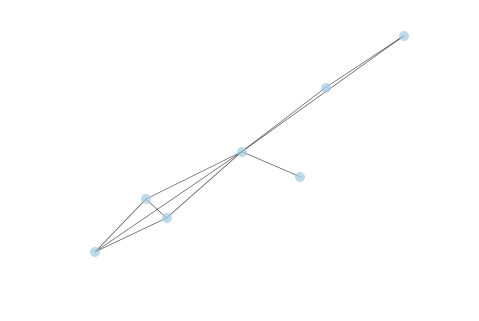

rank_ID  \
FLUX CN ID 4 CN label 4                                                    
Imp  4804    Uncoated kraft paper and paperboard, in rolls o...    23274   
Exp  4819    Cartons, boxes, cases, bags and other packing c...    21768   
Imp  4805    Other uncoated paper and paperboard, in rolls o...    10359   
Exp  4805    Other uncoated paper and paperboard, in rolls o...     7049   
     4804    Uncoated kraft paper and paperboard, in rolls o...     4199   
Imp  8431    Parts suitable for use solely or principally wi...     2850   

                                                                   value  \
FLUX CN ID 4 CN label 4                                                    
Imp  4804    Uncoated kraft paper and paperboard, in rolls o...  1155358   
Exp  4819    Cartons, boxes, cases, bags and other packing c...   233400   
Imp  4805    Other uncoated paper and paperboard, in rolls o...   645815   
Exp  4805    Other uncoated paper and paperboard, in rolls o...   178212   
     4804    Uncoated kraft paper and paperboard, in rolls o...    47099   
Imp  8431    Parts suitable for use solely or principally wi...     3182   

                                                                 counts  
FLUX CN ID 4 CN label 4                                                  
Imp  4804    Uncoated kraft paper and paperboard, in rolls o...      18  
Exp  4819    Cartons, boxes, cases, bags and other packing c...      11  
Imp  4805    Other uncoated paper and paperboard, in rolls o...       9  
Exp  4805    Other uncoated paper and paperboard, in rolls o...       3  
     4804    Uncoated kraft paper and paperboard, in rolls o...       1  
Imp  8431    Parts suitable for use solely or principally wi...       1

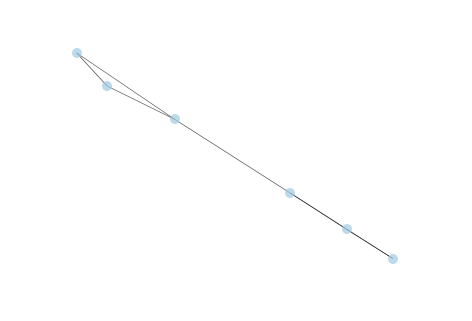

rank_ID  \
FLUX CN ID 4 CN label 4                                                    
Exp  8425    Pulley tackle and hoists other than skip hoists...     5349   
     8431    Parts suitable for use solely or principally wi...     8386   
Imp  8427    Fork-lift trucks; other works trucks fitted wit...     8303   
     8431    Parts suitable for use solely or principally wi...    16304   
Exp  8427    Fork-lift trucks; other works trucks fitted wit...     6598   
     8479    Machines and mechanical appliances having indiv...    11433   
Imp  7318    Screws, bolts, nuts, coach screws, screw hooks,...     5909   
     8466    Parts and accessories suitable for use solely o...     4182   
Exp  8466    Parts and accessories suitable for use solely o...     4182   
Imp  8479    Machines and mechanical appliances having indiv...     2872   

                                                                  value  \
FLUX CN ID 4 CN label 4                                                   
Exp  8425    Pulley tackle and hoists other than skip hoists...  697167   
     8431    Parts suitable for use solely or principally wi...   67120   
Imp  8427    Fork-lift trucks; other works trucks fitted wit...  441136   
     8431    Parts suitable for use solely or principally wi...   99436   
Exp  8427    Fork-lift trucks; other works trucks fitted wit...    6023   
     8479    Machines and mechanical appliances having indiv...  520398   
Imp  7318    Screws, bolts, nuts, coach screws, screw hooks,...     310   
     8466    Parts and accessories suitable for use solely o...    4669   
Exp  8466    Parts and accessories suitable for use solely o...    1280   
Imp  8479    Machines and mechanical appliances having indiv...     215   

                                                                 counts  
FLUX CN ID 4 CN label 4                                                  
Exp  8425    Pulley tackle and hoists other than skip hoists...      20  
     8431    Parts suitable for use solely or principally wi...      10  
Imp  8427    Fork-lift trucks; other works trucks fitted wit...       9  
     8431    Parts suitable for use solely or principally wi...       6  
Exp  8427    Fork-lift trucks; other works trucks fitted wit...       4  
     8479    Machines and mechanical appliances having indiv...       3  
Imp  7318    Screws, bolts, nuts, coach screws, screw hooks,...       2  
     8466    Parts and accessories suitable for use solely o...       2  
Exp  8466    Parts and accessories suitable for use solely o...       1  
Imp  8479    Machines and mechanical appliances having indiv...       1

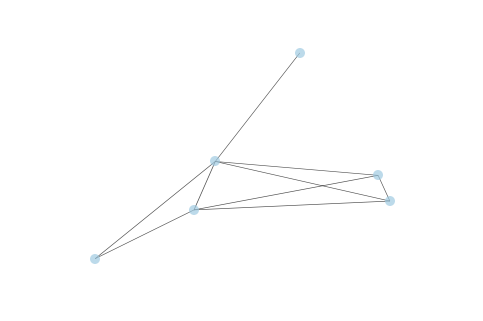

rank_ID  \
FLUX CN ID 4 CN label 4                                                    
Exp  8414    Air or vacuum pumps, air or other gas compresso...     8824   
Imp  8414    Air or vacuum pumps, air or other gas compresso...    13147   
Exp  8409    Parts suitable for use solely or principally wi...     6765   
Imp  8466    Parts and accessories suitable for use solely o...    13035   
     8409    Parts suitable for use solely or principally wi...    11927   
Exp  8207    Interchangeable tools for hand tools, whether o...     6880   
Imp  7325    Other cast articles of iron or steel                     32   
     8207    Interchangeable tools for hand tools, whether o...     3745   

                                                                    value  \
FLUX CN ID 4 CN label 4                                                     
Exp  8414    Air or vacuum pumps, air or other gas compresso...  26009598   
Imp  8414    Air or vacuum pumps, air or other gas compresso...   2939286   
Exp  8409    Parts suitable for use solely or principally wi...    493162   
Imp  8466    Parts and accessories suitable for use solely o...     28153   
     8409    Parts suitable for use solely or principally wi...     66118   
Exp  8207    Interchangeable tools for hand tools, whether o...      4747   
Imp  7325    Other cast articles of iron or steel                 2946300   
     8207    Interchangeable tools for hand tools, whether o...      2600   

                                                                 counts  
FLUX CN ID 4 CN label 4                                                  
Exp  8414    Air or vacuum pumps, air or other gas compresso...      33  
Imp  8414    Air or vacuum pumps, air or other gas compresso...       9  
Exp  8409    Parts suitable for use solely or principally wi...       8  
Imp  8466    Parts and accessories suitable for use solely o...       5  
     8409    Parts suitable for use solely or principally wi...       2  
Exp  8207    Interchangeable tools for hand tools, whether o...       1  
Imp  7325    Other cast articles of iron or steel                     1  
     8207    Interchangeable tools for hand tools, whether o...       1

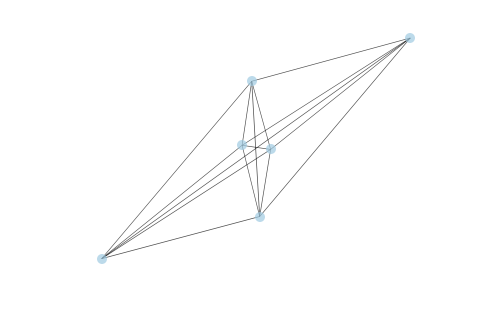

rank_ID  \
FLUX CN ID 4 CN label 4                                                    
Exp  1806    Chocolate and other food preparations containin...    23221   
Imp  1806    Chocolate and other food preparations containin...    13812   
Exp  1704    Sugar confectionery (including white chocolate)...     6738   
Imp  1704    Sugar confectionery (including white chocolate)...    16483   
Exp  1904    Prepared foods obtained by the swelling or roas...     4346   
Imp  3920    Other plates, sheets, film, foil and strip, of ...     9879   
Exp  2202    Waters, including mineral waters and aerated wa...     5718   
Imp  1803    Cocoa paste, whether or not defatted                   1020   
     1904    Prepared foods obtained by the swelling or roas...     4346   
     9403    Other furniture and parts thereof                      2258   

                                                                  value  \
FLUX CN ID 4 CN label 4                                                   
Exp  1806    Chocolate and other food preparations containin...  865053   
Imp  1806    Chocolate and other food preparations containin...  275165   
Exp  1704    Sugar confectionery (including white chocolate)...  156466   
Imp  1704    Sugar confectionery (including white chocolate)...  246544   
Exp  1904    Prepared foods obtained by the swelling or roas...  141390   
Imp  3920    Other plates, sheets, film, foil and strip, of ...   93817   
Exp  2202    Waters, including mineral waters and aerated wa...      99   
Imp  1803    Cocoa paste, whether or not defatted                676454   
     1904    Prepared foods obtained by the swelling or roas...   15142   
     9403    Other furniture and parts thereof                      230   

                                                                 counts  
FLUX CN ID 4 CN label 4                                                  
Exp  1806    Chocolate and other food preparations containin...      18  
Imp  1806    Chocolate and other food preparations containin...       9  
Exp  1704    Sugar confectionery (including white chocolate)...       6  
Imp  1704    Sugar confectionery (including white chocolate)...       6  
Exp  1904    Prepared foods obtained by the swelling or roas...       3  
Imp  3920    Other plates, sheets, film, foil and strip, of ...       3  
Exp  2202    Waters, including mineral waters and aerated wa...       1  
Imp  1803    Cocoa paste, whether or not defatted                     1  
     1904    Prepared foods obtained by the swelling or roas...       1  
     9403    Other furniture and parts thereof                        1

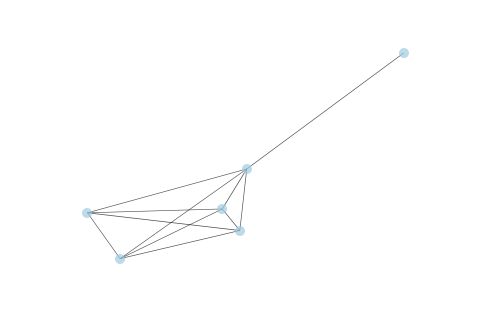

rank_ID  \
FLUX CN ID 4 CN label 4                                                    
Exp  8708    Parts and accessories of the motor vehicles of ...    16491   
Imp  7318    Screws, bolts, nuts, coach screws, screw hooks,...    20185   
     8708    Parts and accessories of the motor vehicles of ...    17699   
Exp  8716    Trailers and semi-trailers; other vehicles, not...     9699   
Imp  7208    Flat-rolled products of iron or non-alloy steel...    10448   
     4407    Wood sawn or chipped lengthwise, sliced or peel...     6005   
     8433    Harvesting or threshing machinery, including st...     3568   
     8716    Trailers and semi-trailers; other vehicles, not...     3694   

                                                                  value  \
FLUX CN ID 4 CN label 4                                                   
Exp  8708    Parts and accessories of the motor vehicles of ...  410188   
Imp  7318    Screws, bolts, nuts, coach screws, screw hooks,...   95536   
     8708    Parts and accessories of the motor vehicles of ...  293816   
Exp  8716    Trailers and semi-trailers; other vehicles, not...  325807   
Imp  7208    Flat-rolled products of iron or non-alloy steel...  232441   
     4407    Wood sawn or chipped lengthwise, sliced or peel...   19945   
     8433    Harvesting or threshing machinery, including st...   70296   
     8716    Trailers and semi-trailers; other vehicles, not...   26560   

                                                                 counts  
FLUX CN ID 4 CN label 4                                                  
Exp  8708    Parts and accessories of the motor vehicles of ...       9  
Imp  7318    Screws, bolts, nuts, coach screws, screw hooks,...       8  
     8708    Parts and accessories of the motor vehicles of ...       7  
Exp  8716    Trailers and semi-trailers; other vehicles, not...       5  
Imp  7208    Flat-rolled products of iron or non-alloy steel...       3  
     4407    Wood sawn or chipped lengthwise, sliced or peel...       1  
     8433    Harvesting or threshing machinery, including st...       1  
     8716    Trailers and semi-trailers; other vehicles, not...       1

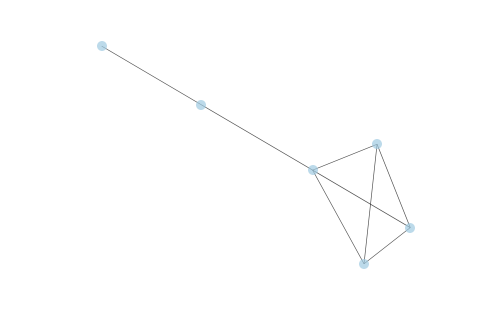

rank_ID  \
FLUX CN ID 4 CN label 4                                                    
Exp  4811    Paper, paperboard, cellulose wadding and webs o...     8827   
     3919    Self-adhesive plates, sheets, film, foil, tape,...     3004   
Imp  4811    Paper, paperboard, cellulose wadding and webs o...    11558   
     7607    Aluminium foil (whether or not printed or backe...    11712   
Exp  3923    Articles for the conveyance or packing of goods...     1350   
     7607    Aluminium foil (whether or not printed or backe...     4681   
     8309    Stoppers, caps and lids (including crown corks,...     5889   
Imp  3920    Other plates, sheets, film, foil and strip, of ...     1712   
     3923    Articles for the conveyance or packing of goods...     1350   
     3208    Paints and varnishes (including enamels and lac...     1677   
     3919    Self-adhesive plates, sheets, film, foil, tape,...     2642   

                                                                   value  \
FLUX CN ID 4 CN label 4                                                    
Exp  4811    Paper, paperboard, cellulose wadding and webs o...  3899043   
     3919    Self-adhesive plates, sheets, film, foil, tape,...   258429   
Imp  4811    Paper, paperboard, cellulose wadding and webs o...   466749   
     7607    Aluminium foil (whether or not printed or backe...   227998   
Exp  3923    Articles for the conveyance or packing of goods...   108336   
     7607    Aluminium foil (whether or not printed or backe...   730736   
     8309    Stoppers, caps and lids (including crown corks,...   111641   
Imp  3920    Other plates, sheets, film, foil and strip, of ...    84949   
     3923    Articles for the conveyance or packing of goods...     2128   
     3208    Paints and varnishes (including enamels and lac...    21038   
     3919    Self-adhesive plates, sheets, film, foil, tape,...    14058   

                                                                 counts  
FLUX CN ID 4 CN label 4                                                  
Exp  4811    Paper, paperboard, cellulose wadding and webs o...      21  
     3919    Self-adhesive plates, sheets, film, foil, tape,...      11  
Imp  4811    Paper, paperboard, cellulose wadding and webs o...      10  
     7607    Aluminium foil (whether or not printed or backe...       6  
Exp  3923    Articles for the conveyance or packing of goods...       5  
     7607    Aluminium foil (whether or not printed or backe...       4  
     8309    Stoppers, caps and lids (including crown corks,...       3  
Imp  3920    Other plates, sheets, film, foil and strip, of ...       3  
     3923    Articles for the conveyance or packing of goods...       2  
     3208    Paints and varnishes (including enamels and lac...       1  
     3919    Self-adhesive plates, sheets, film, foil, tape,...       1

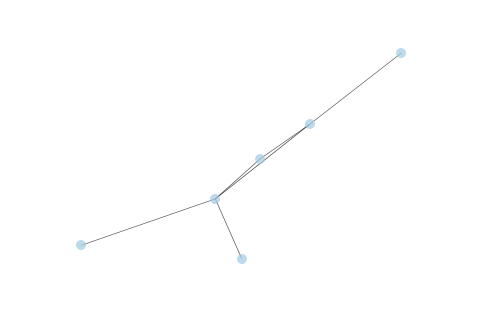

rank_ID  \
FLUX CN ID 4 CN label 4                                                    
Imp  3304    Beauty or make-up preparations and preparations...     8309   
Exp  3303    Perfumes and toilet waters                            18792   
     3304    Beauty or make-up preparations and preparations...     4210   
     3307    Pre-shave, shaving or aftershave preparations, ...     7779   
Imp  3926    Other articles of plastics and articles of othe...     9867   
     4819    Cartons, boxes, cases, bags and other packing c...     2650   
     7010    Carboys, bottles, flasks, jars, pots, phials, a...     6444   
     9616    Scent sprays and similar toilet sprays, and mou...     1706   
     3307    Pre-shave, shaving or aftershave preparations, ...     1560   

                                                                   value  \
FLUX CN ID 4 CN label 4                                                    
Imp  3304    Beauty or make-up preparations and preparations...    55120   
Exp  3303    Perfumes and toilet waters                          1818411   
     3304    Beauty or make-up preparations and preparations...   304726   
     3307    Pre-shave, shaving or aftershave preparations, ...   100138   
Imp  3926    Other articles of plastics and articles of othe...     8351   
     4819    Cartons, boxes, cases, bags and other packing c...      539   
     7010    Carboys, bottles, flasks, jars, pots, phials, a...    68672   
     9616    Scent sprays and similar toilet sprays, and mou...    76105   
     3307    Pre-shave, shaving or aftershave preparations, ...    31441   

                                                                 counts  
FLUX CN ID 4 CN label 4                                                  
Imp  3304    Beauty or make-up preparations and preparations...      80  
Exp  3303    Perfumes and toilet waters                              14  
     3304    Beauty or make-up preparations and preparations...       5  
     3307    Pre-shave, shaving or aftershave preparations, ...       4  
Imp  3926    Other articles of plastics and articles of othe...       2  
     4819    Cartons, boxes, cases, bags and other packing c...       2  
     7010    Carboys, bottles, flasks, jars, pots, phials, a...       2  
     9616    Scent sprays and similar toilet sprays, and mou...       2  
     3307    Pre-shave, shaving or aftershave preparations, ...       1

In [253]:
from IPython.display import display, HTML

r = 20
k = r*[0.15]; k[0] = 0.05
for i in range(r):
    pos = nx.spring_layout(grcc[i], k=k[i])
    nx.draw(grcc[i], pos = pos, node_color='#A0CBE2', width=edges['weight'], edge_cmap=plt.cm.Blues, with_labels=False, alpha = .7, linewidths= 0, node_size = 100)
    plt.show()

    display(df_display.loc[grcc[i].nodes()].reset_index().groupby(['FLUX','CN ID 4', 'CN label 4']).sum().sort_values(by = 'counts', ascending = False).head(20))

In [46]:
# df_display.loc[df_display['VFTE'] > 1000]

# ImpExp_ind
# ImpExpBool.loc[ImpExpBool.duplicated()]

In [54]:
from numpy import log10
import matplotlib.pyplot as plt
%matplotlib inline

firm_size = log10(df_display.reset_index().groupby('rank_ID').sum()[['VFTE']])
firm_size.columns = ['firm_size']
# log_bins = firm_size.round(1).reset_index()
# log_bins.columns = ['rank_ID', 'bin']

# df_display.reset_index().merge(log_bins).groupby('bin').sum()['VFTE'].plot(marker = 'o')
# plt.show()

firm_size.loc[firm_size.firm_size > 5]

,firm_size
rank_ID,
1,8.594317
2,8.311841
3,8.234950
4,8.201285
5,8.104023
6,8.005174
7,7.896604
8,7.888329
9,7.876642


In [130]:


df_display.iloc[30000:30300].style.bar(subset=['value', 'counts'], color='#d65f5f')

In [6]:
dg_ = df_.merge(CPA_full[['CPA ID 6', 'CPA label 3']], left_on = 'CPA6', right_on = 'CPA ID 6')
dg_ = dg_.loc[dg_['VFTE'] > 0]

# dg_ = dg_.groupby(['Description', 'CPA label 3']).sum()[['VFTE']].sort_values(by = 'VFTE', ascending = False)

# dg_

NameError: name 'df_' is not defined

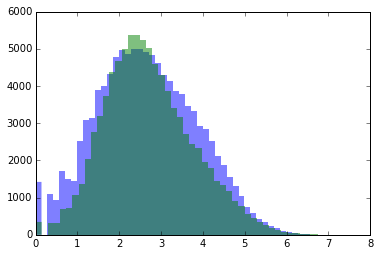

In [292]:
import matplotlib.pyplot as plt
%matplotlib inline
from numpy import log10

# Column 3.  FLUX: flow type [1 = Import ouside UE;  2 = Export outside UE; 3 = Import within UE, 4=export within UE]/# Column 4.  ID code domestic firm

# plt.hist(log10(dg_.loc[dg_.FLUX == 1]['VFTE'].values), 50, alpha = .5, edgecolor = 'None')
# plt.hist(log10(dg_.loc[dg_.FLUX == 2]['VFTE'].values), 50, alpha = .5, edgecolor = 'None')
plt.hist(log10(dg_.loc[dg_.FLUX == 3]['VFTE'].values), 50, alpha = .5, edgecolor = 'None')
plt.hist(log10(dg_.loc[dg_.FLUX == 4]['VFTE'].values), 50, alpha = .5, edgecolor = 'None')
plt.show()

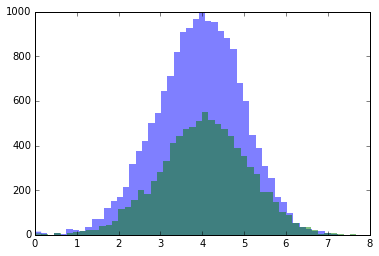

In [304]:

plt.hist(log10(dg_.loc[dg_.FLUX == 3].groupby('ID').sum()['VFTE'].values), 50, alpha = .5, edgecolor = 'None')
plt.hist(log10(dg_.loc[dg_.FLUX == 4].groupby('ID').sum()['VFTE'].values), 50, alpha = .5, edgecolor = 'None')
plt.show()

In [316]:
import seaborn as sns

cm = sns.light_palette("green", as_cmap=True)


In [379]:
F = 3

df = pd.DataFrame(dg_.loc[dg_.FLUX == F].groupby(['ID'])['CN ID 4'].nunique())
df2 = pd.DataFrame(dg_.loc[dg_.FLUX == F].groupby(['ID'])['PYOD'].nunique())


variety = pd.concat([df, df2], axis = 1).clip(0, 15).reset_index().groupby(['CN ID 4', 'PYOD']).count()
variety = 100*variety/variety.sum()

v_df = variety.unstack().sort_index(ascending = False)
s = v_df.round(3).style.background_gradient(cmap=cm, low=0, high=.5)
s

In [376]:
F = 4

df = pd.DataFrame(dg_.loc[dg_.FLUX == F].groupby(['ID'])['CN ID 4'].nunique())
df2 = pd.DataFrame(dg_.loc[dg_.FLUX == F].groupby(['ID'])['PYOD'].nunique())


variety = pd.concat([df, df2], axis = 1).clip(0, 15).reset_index().groupby(['CN ID 4', 'PYOD']).count()
variety = 100*variety/variety.sum()

v_df = variety.unstack().sort_index(ascending = False)
s = v_df.round(3).style.background_gradient(cmap=cm, low=0, high=.5)
s

In [374]:
F = 3

df = pd.DataFrame(dg_.loc[dg_.FLUX == F].groupby(['ID'])['CN ID 4'].nunique())
df2 = pd.DataFrame(dg_.loc[dg_.FLUX == F].groupby(['ID'])['PYOD'].nunique())
df3 = pd.DataFrame(dg_.loc[dg_.FLUX == F].groupby(['ID'])['VFTE'].sum())

dist = pd.concat([df, df2], axis = 1).clip(0, 15)
dist = pd.concat([dist, df3], axis = 1).groupby(['CN ID 4', 'PYOD']).sum()
dist = 100*dist/dist.sum()

v_df = dist.unstack().sort_index(ascending = False)
s = v_df.round(3).style.background_gradient(cmap=cm, low=0, high=.5)
s

In [375]:
F = 4

df = pd.DataFrame(dg_.loc[dg_.FLUX == F].groupby(['ID'])['CN ID 4'].nunique())
df2 = pd.DataFrame(dg_.loc[dg_.FLUX == F].groupby(['ID'])['PYOD'].nunique())
df3 = pd.DataFrame(dg_.loc[dg_.FLUX == F].groupby(['ID'])['VFTE'].sum())

dist = pd.concat([df, df2], axis = 1).clip(0, 15)
dist = pd.concat([dist, df3], axis = 1).groupby(['CN ID 4', 'PYOD']).sum()
dist = 100*dist/dist.sum()

v_df = dist.unstack().sort_index(ascending = False)
s = v_df.round(3).style.background_gradient(cmap=cm, low=0, high=.5)
s

In [270]:
df_ = df.merge(CN_full[['Code', 'CN ID 4']].drop_duplicates(), left_on = 'NC8', right_on = 'Code')
df_ = df_.merge(CN_full.loc[CN_full.Level == 3][['CN ID 4', 'Description']])
df_

,YEAR,MONTH,FLUX,ID,DEPT,NC8,CPA6,PYOD,PAYP,VAT,...,DEVFAC,VFTE,VART,D_MASSE,MASSE,USUP,USUP_MT,Code,CN ID 4,Description
0,2011,9,3,505308189,93,39269097,222929,CN,BE,NaN,...,NaN,984,984,1,138,NaN,0,39269097,3926,Other articles of plastics and articles of oth...
1,2011,3,3,384560942,45,39269097,222929,SK,DE,NaN,...,NaN,131,131,1,4,NaN,0,39269097,3926,Other articles of plastics and articles of oth...
2,2011,2,4,438183170,59,39269097,222929,DE,NaN,DE0161348,...,NaN,1761,1761,1,290,NaN,0,39269097,3926,Other articles of plastics and articles of oth...
3,2011,9,3,582135919,95,39269097,222929,IT,IT,NaN,...,NaN,27330,27330,1,6050,NaN,0,39269097,3926,Other articles of plastics and articles of oth...
4,2011,5,3,668502966,67,39269097,222929,SE,SE,NaN,...,NaN,4881,4881,1,151,NaN,0,39269097,3926,Other articles of plastics and articles of oth...
5,2011,2,3,398231951,02,39269097,222929,BE,BE,NaN,...,NaN,593,593,1,12,NaN,0,39269097,3926,Other articles of plastics and articles of oth...
6,2011,7,1,380788083,67,39269097,222929,CN,CH,NaN,...,CHF,3,3,0,0,NaN,0,39269097,3926,Other articles of plastics and articles of oth...
7,2011,12,1,999999999,10,39269097,222929,HK,BE,NaN,...,USD,97,1293,1,95,NaN,0,39269097,3926,Other articles of plastics and articles of oth...
8,2011,8,3,383719242,80,39269097,222929,JP,NL,NaN,...,NaN,79,79,1,5,NaN,0,39269097,3926,Other articles of plastics and articles of oth...
9,2011,11,3,964201438,77,39269097,222929,DE,DE,NaN,...,NaN,6659,6659,1,139,NaN,0,39269097,3926,Other articles of plastics and articles of oth...


In [191]:
df_.groupby('Description').sum()[['VFTE']].sort_values(by = 'VFTE', ascending = False)
# df2.style.bar(color='#d65f5f')

# 8703 	
# 3004 	
# 2709 	
# 8517 	
# 8708

,VFTE
Description,
"Motor cars and other motor vehicles principally designed for the transport of persons (other than those of heading 8702), including station wagons and racing cars",329214819
"Medicaments (excluding goods of heading 3002, 3005 or 3006) consisting of mixed or unmixed products for therapeutic or prophylactic uses, put up in measured doses (including those in the form of transdermal administration systems) or in forms or packings for retail sale",321007916
"Petroleum oils and oils obtained from bituminous minerals, crude",315285542
"Telephone sets, including telephones for cellular networks or for other wireless networks; other apparatus for the transmission or reception of voice, images or other data, including apparatus for communication in a wired or wireless network (such as a local or wide area network), other than transmission or reception apparatus of heading 8443, 8525, 8527 or 8528",254161296
Parts and accessories of the motor vehicles of headings 8701 to 8705,234782630
Heterocyclic compounds with nitrogen hetero-atom(s) only,208424815
Electronic integrated circuits,110180536
"Petroleum oils and oils obtained from bituminous minerals, other than crude; preparations not elsewhere specified or included, containing by weight 70 % or more of petroleum oils or of oils obtained from bituminous minerals, these oils being the basic constituents of the preparations; waste oils",98086917
Motor vehicles for the transport of goods,97493023


In [215]:
# ix = df_.groupby(['ID']).sum().sort_values(by = 'VFTE', ascending = False).reset_index()['ID'].values
# df_.loc[df_['CN ID 4'] == '8703'].groupby(['ID', 'NC8', 'PYOD']).sum()
df_


,YEAR,MONTH,FLUX,ID,DEPT,NC8,CPA6,PYOD,PAYP,VAT,...,DEVFAC,VFTE,VART,D_MASSE,MASSE,USUP,USUP_MT,Code,CN ID 4,Description
0,2011,9,3,505308189,93,39269097,222929,CN,BE,NaN,...,NaN,984,984,1,138,NaN,0,39269097,3926,Other articles of plastics and articles of oth...
1,2011,3,3,384560942,45,39269097,222929,SK,DE,NaN,...,NaN,131,131,1,4,NaN,0,39269097,3926,Other articles of plastics and articles of oth...
2,2011,2,4,438183170,59,39269097,222929,DE,NaN,DE0161348,...,NaN,1761,1761,1,290,NaN,0,39269097,3926,Other articles of plastics and articles of oth...
3,2011,9,3,582135919,95,39269097,222929,IT,IT,NaN,...,NaN,27330,27330,1,6050,NaN,0,39269097,3926,Other articles of plastics and articles of oth...
4,2011,5,3,668502966,67,39269097,222929,SE,SE,NaN,...,NaN,4881,4881,1,151,NaN,0,39269097,3926,Other articles of plastics and articles of oth...
5,2011,2,3,398231951,02,39269097,222929,BE,BE,NaN,...,NaN,593,593,1,12,NaN,0,39269097,3926,Other articles of plastics and articles of oth...
6,2011,7,1,380788083,67,39269097,222929,CN,CH,NaN,...,CHF,3,3,0,0,NaN,0,39269097,3926,Other articles of plastics and articles of oth...
7,2011,12,1,999999999,10,39269097,222929,HK,BE,NaN,...,USD,97,1293,1,95,NaN,0,39269097,3926,Other articles of plastics and articles of oth...
8,2011,8,3,383719242,80,39269097,222929,JP,NL,NaN,...,NaN,79,79,1,5,NaN,0,39269097,3926,Other articles of plastics and articles of oth...
9,2011,11,3,964201438,77,39269097,222929,DE,DE,NaN,...,NaN,6659,6659,1,139,NaN,0,39269097,3926,Other articles of plastics and articles of oth...


In [15]:
#unique entries on each column
for i in range(18):
    print len(df.loc[df.FLUX == 4].iloc[:, i].unique())

1
12
1
13386
97
6569
1513
26
1
70382
1
1
23482
23904
2
11880
25
3450


In [12]:
df.loc[df.FLUX == 4].groupby('PYOD').count().sort_values(by = 'VFTE', ascending = False)

,YEAR,MONTH,FLUX,ID,DEPT,NC8,CPA6,PAYP,VAT,PRIFAC,DEVFAC,VFTE,VART,D_MASSE,MASSE,USUP,USUP_MT
PYOD,,,,,,,,,,,,,,,,,
BE,23716,23716,23716,23716,23716,23716,23716,0,23716,0,0,23716,23716,23716,23716,7323,23716
DE,23379,23379,23379,23379,23379,23379,23379,0,23379,0,0,23379,23379,23379,23379,7377,23379
IT,18747,18747,18747,18747,18747,18747,18747,0,18747,0,0,18747,18747,18747,18747,6768,18747
ES,16996,16996,16996,16996,16996,16996,16996,0,16996,0,0,16996,16996,16996,16996,5611,16996
GB,11110,11110,11110,11110,11110,11110,11110,0,11110,0,0,11110,11110,11110,11110,3878,11110
NL,7431,7431,7431,7431,7431,7431,7431,0,7431,0,0,7431,7431,7431,7431,2522,7431
PT,4616,4616,4616,4616,4616,4616,4616,0,4616,0,0,4616,4616,4616,4616,1562,4616
LU,3847,3847,3847,3847,3847,3847,3847,0,3847,0,0,3847,3847,3847,3847,1048,3847
PL,3392,3392,3392,3392,3392,3392,3392,0,3392,0,0,3392,3392,3392,3392,962,3392


In [16]:
df.loc[df.FLUX == 4].groupby('PYOD').sum()

,YEAR,MONTH,FLUX,ID,NC8,PRIFAC,VFTE,VART,D_MASSE,MASSE,USUP,USUP_MT
PYOD,,,,,,,,,,,,
AT,6662443,21483,13252,1523939965280,207846122080,NaN,38199260,39149438,3141,7396420,26537.0,282349
BE,47692876,153536,94864,10811466126196,1281841820125,NaN,281368721,322270575,22905,272240850,160909.0,35852910
BG,1415744,4771,2816,340640644440,44054198181,NaN,6656084,7345171,682,1909518,4718.0,237849
CY,846631,2643,1684,195776867464,24910680597,NaN,2861080,2868527,400,3582771,3506.0,301541
CZ,4432244,14562,8816,1064699221215,137704575603,NaN,30730021,31696584,2149,8198228,12399.0,767062
DE,47015169,150802,93516,10781148839400,1384430170876,NaN,529469966,609151504,22657,273941757,163375.0,38773933
DK,4108473,13309,8172,972176222003,118861206943,NaN,13458477,13568440,1971,3796795,15452.0,500226
EE,868752,2826,1728,209187701845,27077645507,NaN,2849559,2855484,408,344913,3845.0,90394
ES,34178956,109221,67984,7721428161839,1000356485266,NaN,251707615,280366785,16336,206886774,127011.0,15613232


In [26]:
df.loc[df.FLUX == 4].groupby(['ID', 'NC8', 'PYOD']).count().sort_values(by = 'YEAR', ascending  =False)

YEAR  MONTH  FLUX  DEPT  CPA6  PAYP  VAT  PRIFAC  \
ID        NC8      PYOD                                                     
388896904 90031900 DE      91     91    91    91    91     0   91       0   
          90039000 DE      89     89    89    89    89     0   89       0   
405403965 85393190 IT      80     80    80    80    80     0   80       0   
          85392192 IT      75     75    75    75    75     0   75       0   
512466913 85423990 DE      69     69    69    69    69     0   69       0   
493265284 30049000 BE      66     66    66    66    66     0   66       0   
405403965 85392290 IT      64     64    64    64    64     0   64       0   
384427290 42029291 DE      62     62    62    62    62     0   62       0   
398360123 33049900 DE      60     60    60    60    60     0   60       0   
                   IT      57     57    57    57    57     0   57       0   
405403965 85393110 IT      52     52    52    52    52     0   52       0   
          85392198 IT      52     52    52    52    52     0   52       0   
494802648 90013000 DE      51     51    51    51    51     0   51       0   
512466913 85411000 DE      50     50    50    50    50     0   50       0   
445340573 83062900 DE      48     48    48    48    48     0   48       0   
398360123 33049900 ES      48     48    48    48    48     0   48       0   
512466913 85423190 DE      46     46    46    46    46     0   46       0   
515155844 87149990 DE      45     45    45    45    45     0   45       0   
405403965 85392192 DE      44     44    44    44    44     0   44       0   
          85393190 DE      43     43    43    43    43     0   43       0   
          85392198 DE      43     43    43    43    43     0   43       0   
384427290 61091000 DE      43     43    43    43    43     0   43       0   
          42029298 DE      42     42    42    42    42     0   42       0   
364800276 64039996 DE      42     42    42    42    42     0   42       0   
392127635 90041010 DE      42     42    42    42    42     0   42       0   
405403965 85392210 DE      41     41    41    41    41     0   41       0   
          85392290 DE      41     41    41    41    41     0   41       0   
342136710 90031100 IT      41     41    41    41    41     0   41       0   
512466913 85366930 DE      40     40    40    40    40     0   40       0   
384427290 61091000 ES      39     39    39    39    39     0   39       0   
...                       ...    ...   ...   ...   ...   ...  ...     ...   
388734568 84733020 SE       1      1     1     1     1     0    1       0   
          84717050 NL       1      1     1     1     1     0    1       0   
                   DE       1      1     1     1     1     0    1       0   
          84715000 PL       1      1     1     1     1     0    1       0   
          84714100 IT       1      1     1     1     1     0    1       0   
                   DK       1      1     1     1     1     0    1       0   
          84439990 DE       1      1     1     1     1     0    1       0   
          84433191 GB       1      1     1     1     1     0    1       0   
388745317 8023200  ES       1      1     1     1     1     0    1       0   
                   NL       1      1     1     1     1     0    1       0   
388746109 30061090 BE       1      1     1     1     1     0    1       0   
                   PT       1      1     1     1     1     0    1       0   
388796708 7082000  IT       1      1     1     1     1     0    1       0   
          7061000  DE       1      1     1     1     1     0    1       0   
388781023 82084000 PL       1      1     1     1     1     0    1       0   
                   BE       1      1     1     1     1     0    1       0   
388778862 84669400 SE       1      1     1     1     1     0    1       0   
                   RO       1      1     1     1     1     0    1       0   
                   FI       1      1     1     1     1     0    1       0   
          84662020 DE

In [33]:
df.loc[df.NC8.astype(str).str[:1] == '02']

,YEAR,MONTH,FLUX,ID,DEPT,NC8,CPA6,PYOD,PAYP,VAT,PRIFAC,DEVFAC,VFTE,VART,D_MASSE,MASSE,USUP,USUP_MT


In [29]:
df.loc[df.FLUX == 4].groupby(['ID', 'NC8', 'PYOD']).sum()
df_ = df.loc[df.FLUX == 4].groupby(['PYOD']).sum().sort_values(by = 'VFTE', ascending = False)
df_['counts'] = df_['YEAR']/2011
df_['VFTE_pct_cs'] = (df_/df_.sum())['VFTE'].cumsum()
df_.head(30)

,YEAR,MONTH,FLUX,ID,NC8,PRIFAC,VFTE,VART,D_MASSE,MASSE,USUP,USUP_MT,counts,VFTE_pct_cs
PYOD,,,,,,,,,,,,,,
DE,47015169,150802,93516,10781148839400,1384430170876,NaN,529469966,609151504,22657,273941757,163375.0,38773933,23379.0,0.230105
IT,37700217,120443,74988,8336693995960,1098823545148,NaN,333049208,339427298,18021,158468055,152925.0,11791891,18747.0,0.374846
BE,47692876,153536,94864,10811466126196,1281841820125,NaN,281368721,322270575,22905,272240850,160909.0,35852910,23716.0,0.497127
GB,22342210,72047,44440,5213086619628,641316591583,NaN,270901766,293172100,10741,101775688,84989.0,21416829,11110.0,0.614860
ES,34178956,109221,67984,7721428161839,1000356485266,NaN,251707615,280366785,16336,206886774,127011.0,15613232,16996.0,0.724250
NL,14943741,47447,29724,3459699538127,444092772805,NaN,166298382,168200152,7139,146319333,55722.0,23374662,7431.0,0.796523
PL,6821312,22343,13568,1651289560958,213159584945,NaN,74056165,75740666,3314,27813841,21420.0,4116023,3392.0,0.828707
IE,3096940,9905,6160,702015560498,83971238124,NaN,64219013,75298647,1480,10389131,13446.0,3586923,1540.0,0.856616
SE,4943038,16331,9832,1137428053078,155822524117,NaN,52596925,52747697,2383,12630442,14621.0,4676875,2458.0,0.879475
